# 06 - Neural Networks

In this notebook we will learn how to train a simple Multilayer Perceptron for image classification using PyTorch.

[Click here to check guide to install PyTorch locally.](https://pytorch.org/get-started/locally/)

You can find additional information [here](https://pytorch.org/tutorials/beginner/basics/intro.html).


In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm

## Load dataset

The torchvision package contains a few datasets. We will use the MNIST dataset of handwritten digits.

The dataset comes separated into training and test sets. We will further separate the test set into two smaller sets: validation and test.


In [2]:
# Define transformations that are applied to the image
data_aug = transforms.Compose([transforms.ToTensor()]) # ToTensor() transforms an image into a tensor, normalizing it into values between 0 and 1

# Load training data from MNIST into directory defined in "root"
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=data_aug,
)

# Load test data from MNIST into directory defined in "root"
validation_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=data_aug,
)

# Separate test images into validation (80%) and testing (20%)
indices = list(range(len(validation_data)))
np.random.shuffle(indices)

test_size = 0.2 * len(indices)
split = int(np.floor(test_size))
val_idx, test_idx = indices[split:], indices[:split]

val_sampler = SubsetRandomSampler(val_idx)
test_sampler = SubsetRandomSampler(test_idx)

100%|██████████| 9912422/9912422 [00:00<00:00, 251995388.97it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 93468899.56it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 84713083.17it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17787608.56it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Define a data loader that automatically fetches batches of images and their labels

In [3]:
batch_size = 64 # number of images loaded at each time
num_workers = 2 # how many processes are used to load the data

# Define data loaders for the train, test and validation data
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
validation_dataloader = DataLoader(validation_data, sampler=val_sampler, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
test_dataloader = DataLoader(validation_data, sampler=test_sampler, batch_size=1, shuffle=False, num_workers=num_workers, drop_last=False)

## Visualize the Data

Directly using the dataset

In [4]:
# Get the first sample of the training data (contains an image and its label)

sample = training_data[0]

# Get image and print its dimensions
img = sample[0]
print(img.shape)

# Get label and print it
label = sample[1]
print(label)

torch.Size([1, 28, 28])
5


Iterating over the data loader

torch.Size([64, 1, 28, 28])
tensor([1, 1, 8, 9, 3, 7, 3, 2, 9, 1, 7, 6, 8, 2, 0, 1, 2, 3, 9, 7, 9, 9, 1, 6,
        9, 7, 6, 5, 4, 9, 1, 5, 7, 3, 3, 4, 1, 1, 8, 8, 9, 7, 4, 4, 9, 3, 9, 3,
        4, 2, 2, 3, 2, 9, 8, 4, 8, 9, 6, 0, 9, 0, 3, 2])


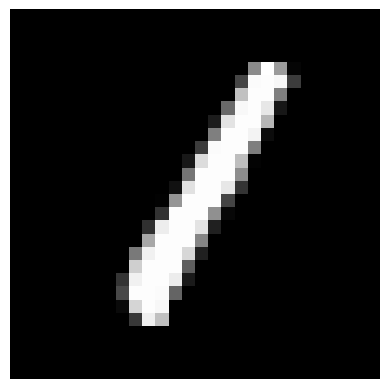

In [5]:
for batch in train_dataloader:
  # Get images of the batch and print their dimensions
  imgs = batch[0]
  print(imgs.shape)

  # Get labels of each image in the batch and print them
  labels = batch[1]
  print(labels)

  # Show first image of the batch
  plt.imshow(imgs[0][0,:,:], cmap='gray')
  plt.axis('off')
  plt.show()

  break

## Defining the model

Create an MLP with the following structure:

1. Dense/linear layer that takes the images as a flattened input vector and generates an output of 512 of dimension.
2. ReLU activation layer
3. Dense/linear layer with 512 input and output
3. ReLU activation layer
4. Dense/linear layer with 10 output channels (10 classes of MNIST)

You can use PyTorch's layers: https://pytorch.org/docs/stable/nn.html (Conv2d, ReLU, Linear, MaxPool2d, Dropout, Flatten)

In [7]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        # TODO: Define model layers here
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28,512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        #TODO: Apply layers to input x and return result
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device) # put model in device (GPU or CPU)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Interpret the implemented architecture and try to answer the following questions:

a) What is the shape (width, and # of channels) of the output tensor after the first layer?

b) And after the first 3 layers (dense+dense+dense)?

c) How many parameters (weights) does the model have? Contrary to Keras, PyTorch does not have an official method for counting the number of parameters of a model, but you can use [torchsummary](https://pypi.org/project/torch-summary/)

In [12]:
# TODO
print("c)")
print("nI * nO + nO(bias) = number of parameters")
print("1st Dense Layer:" + str((784 * 512 + 512)))
print("2nd Dense Layer:" + str((512 * 512 + 512)))
print("3rd Dense Layer:" + str((512 * 10 + 10)))


c)
nI * nO + nO(bias) = number of parameters
1st Dense Layer:401920
2nd Dense Layer:262656
3rd Dense Layer:5130


In [ ]:
#!pip install torch-summary
from torchsummary import summary
summary(model, (1, 28, 28))



## Train the model

In [13]:
# Define loss function
loss_fn = nn.CrossEntropyLoss() # already includes the Softmax activation

# Define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

Define one iteration

In [14]:
def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."

    # Get number of batches
    num_batches = len(dataloader)

    # Set model to train mode or evaluation mode
    if is_train:
      model.train()
    else:
      model.eval()

    # Define variables to save predictions and labels during the epoch
    total_loss = 0.0
    preds = []
    labels = []

    # Enable/disable gradients based on whether the model is in train or evaluation mode
    with torch.set_grad_enabled(is_train):

      # Analyse all batches
      for batch, (X, y) in enumerate(tqdm(dataloader)):

          # Put data in same device as model (GPU or CPU)
          X, y = X.to(device), y.to(device)

          # Forward pass to obtain prediction of the model
          pred = model(X)

          # Compute loss between prediction and ground-truth
          loss = loss_fn(pred, y)

          # Backward pass
          if is_train:
            # Reset gradients in optimizer
            optimizer.zero_grad()
            # Calculate gradients by backpropagating loss
            loss.backward()
            # Update model weights based on the calculated gradients
            optimizer.step()

          # Apply softmax activation to obtain final prediction
          probs = F.softmax(pred, dim=1)
          final_pred = torch.argmax(probs, dim=1)

          # Save training metrics
          total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

          # Add predictions
          preds.extend(final_pred.cpu().numpy())
          labels.extend(y.cpu().numpy())

    return total_loss / num_batches, accuracy_score(labels, preds)

Define training cycle

In [15]:
num_epochs = 10
train_history = {'loss': [], 'accuracy': []}
val_history = {'loss': [], 'accuracy': []}
best_val_loss = np.inf

# Training cycle
print("Start training...")
for t in range(num_epochs):
    print(f"\nEpoch {t+1}")

    # Train model for one iteration on training data
    train_loss, train_acc = epoch_iter(train_dataloader, model, loss_fn, optimizer)
    print(f"Train loss: {train_loss:.3f} \t Train acc: {train_acc:.3f}")

    # Evaluate model on validation data
    val_loss, val_acc = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
    print(f"Val loss: {val_loss:.3f} \t Val acc: {val_acc:.3f}")

    # Save model when validation loss improves
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, 'best_model.pth')

    # Save latest model
    save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
    torch.save(save_dict, 'latest_model.pth')

    # Save training history for plotting purposes
    train_history["loss"].append(train_loss)
    train_history["accuracy"].append(train_acc)

    val_history["loss"].append(val_loss)
    val_history["accuracy"].append(val_acc)

print("Finished")

Start training...

Epoch 1


100%|██████████| 937/937 [00:10<00:00, 92.11it/s] 


Train loss: 2.279 	 Train acc: 0.336


100%|██████████| 125/125 [00:01<00:00, 101.52it/s]


Val loss: 2.254 	 Val acc: 0.550

Epoch 2


100%|██████████| 937/937 [00:09<00:00, 100.84it/s]


Train loss: 2.225 	 Train acc: 0.614


100%|██████████| 125/125 [00:01<00:00, 83.91it/s] 


Val loss: 2.186 	 Val acc: 0.654

Epoch 3


100%|██████████| 937/937 [00:08<00:00, 106.54it/s]


Train loss: 2.137 	 Train acc: 0.653


100%|██████████| 125/125 [00:01<00:00, 63.22it/s]


Val loss: 2.069 	 Val acc: 0.671

Epoch 4


100%|██████████| 937/937 [00:08<00:00, 104.36it/s]


Train loss: 1.985 	 Train acc: 0.680


100%|██████████| 125/125 [00:01<00:00, 108.58it/s]


Val loss: 1.868 	 Val acc: 0.702

Epoch 5


100%|██████████| 937/937 [00:09<00:00, 98.77it/s] 


Train loss: 1.740 	 Train acc: 0.708


100%|██████████| 125/125 [00:01<00:00, 109.28it/s]


Val loss: 1.571 	 Val acc: 0.730

Epoch 6


100%|██████████| 937/937 [00:09<00:00, 97.08it/s] 


Train loss: 1.427 	 Train acc: 0.738


100%|██████████| 125/125 [00:01<00:00, 105.88it/s]


Val loss: 1.249 	 Val acc: 0.773

Epoch 7


100%|██████████| 937/937 [00:09<00:00, 96.92it/s] 


Train loss: 1.140 	 Train acc: 0.775


100%|██████████| 125/125 [00:01<00:00, 107.38it/s]


Val loss: 0.999 	 Val acc: 0.803

Epoch 8


100%|██████████| 937/937 [00:09<00:00, 97.69it/s] 


Train loss: 0.935 	 Train acc: 0.800


100%|██████████| 125/125 [00:01<00:00, 104.74it/s]


Val loss: 0.831 	 Val acc: 0.822

Epoch 9


100%|██████████| 937/937 [00:09<00:00, 97.25it/s]


Train loss: 0.797 	 Train acc: 0.817


100%|██████████| 125/125 [00:01<00:00, 106.99it/s]


Val loss: 0.718 	 Val acc: 0.835

Epoch 10


100%|██████████| 937/937 [00:09<00:00, 101.38it/s]


Train loss: 0.703 	 Train acc: 0.831


100%|██████████| 125/125 [00:02<00:00, 52.60it/s]


Val loss: 0.639 	 Val acc: 0.848
Finished


## Analyse training evolution

Plot loss and accuracy throughout training on train and validation data

In [21]:
# TODO
def plotTrainingHistory(train_history, val_history):
  plt.subplot(2,1,1)
  plt.title("Cross Entropy Loss")
  plt.plot(train_history['loss'], label='train')
  plt.plot(val_history['loss'], label='val')
  plt.legend(loc='best')

  plt.subplot(2,1,2)
  plt.title('Classification Accuracy')
  plt.plot(train_history['accuracy'], label='train')
  plt.plot(val_history['accuracy'],label='val')

  plt.tight_layout()
  plt.legend(loc='best')
  plt.show()

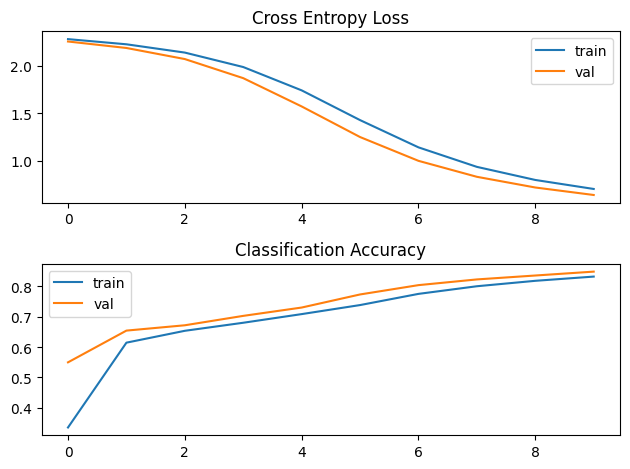

In [22]:
plotTrainingHistory(train_history, val_history)

## Test the model

Evaluate the model in the test set

In [23]:
# TODO
model = NeuralNetwork().to(device)
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model'])

# Evaluate model on test data
test_loss, test_acc = epoch_iter(test_dataloader, model, loss_fn, is_train=False)
print(f"\nTest Loss: {test_loss:.3f} \nTest Accuracy: {test_acc:.3f}")

100%|██████████| 2000/2000 [00:06<00:00, 318.31it/s]


Test Loss: 0.671 
Test Accuracy: 0.822


In [ ]:
def showErrors(model, dataloader, num_examples=20):
    plt.figure(figsize=(15, 15))

    for ind, (X, y) in enumerate(dataloader):
      if ind >= 20: break
      X, y = X.to(device), y.to(device)
      pred = model(X)
      probs = F.softmax(pred, dim=1)
      final_pred = torch.argmax(probs, dim=1)

      plt.subplot(10, 10, ind + 1)
      plt.axis("off")
      plt.text(0, -1, y[0].item(), fontsize=14, color='green') # correct
      plt.text(8, -1, final_pred[0].item(), fontsize=14, color='red')  # predicted
      plt.imshow(X[0][0,:,:].cpu(), cmap='gray')
    plt.show()

In [ ]:
showErrors(model, test_dataloader)

## Additional Challenges

a) As the test accuracy should show, the MNIST dataset is not very challenging, change the code to use Fashion-MNIST and compare the results.

b) Do the same for the CIFAR10 (or CIFAR100) dataset. Note that, in this case, each image is a 32x32 color image; convert it to grayscale or concatenate the RGB channels in one single vector (e.g. using the reshape method).

c) The test accuracy for CIFAR is significantly worse. Try improving the results by using: 1) a deeper architecture, and 2) a different optmizer.

You can load the datasets from [here](https://pytorch.org/vision/stable/datasets.html).
